# LOCOMOTION Activity Recognition using LOSO with LSTM Neural Network

 # Reading the dataset

In [1]:
import pandas as pd
import numpy as np
import glob

import tensorflow as tf
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader

from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score,confusion_matrix, plot_confusion_matrix
import time
from typing import Any
import torch
import torch.nn as nn

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix
from pandas import DataFrame
from keras.models import load_model
import matplotlib.pyplot as plt


files = glob.glob('/data/shk/dl-for-har/tutorial_notebooks/Prof_New/*.csv')

name = [file.split('/')[-1] for file in files]
df = pd.concat(map(pd.read_csv,files),ignore_index = True) #4230213 rows × 10 columns

data = df

clean_data = data[data['locomotion']!='not_labeled']
clean_data = clean_data[data['locomotion'].notna()]
clean_data['locomotion'].replace({'layup':'jumping'},inplace=True)
print('Before_game',len(clean_data))

new_data = clean_data[clean_data.coarse != 'game'] #623758 rows × 10 columns
new_data = new_data.drop(columns='coarse')
new_data = new_data.drop(columns='basketball')
new_data = new_data.iloc[:,:6]
print('new_data',new_data.shape)
print('____')

game_data = clean_data[clean_data.coarse == 'game']
game_data = game_data.drop(columns='coarse')
game_data = game_data.drop(columns='basketball')
game_data = game_data.iloc[:,:6] #45446 rows × 6 columns
print('game_data',game_data.shape)

2022-08-15 09:46:22.924862: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-15 09:46:22.924929: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/shk/anaconda3/envs/adversarial/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Before_game 2710751
new_data (1982320, 6)
____
game_data (728431, 6)


# Labelling the data

In [2]:
label = new_data['locomotion']
x_axis = sorted(label.unique())
y_axis = label.value_counts()

X = new_data.iloc[:,:-1]#.astype(np.float32)

class_names = ['walking','running','standing','sitting','jumping']
num_classes = len(class_names)

def labelling(clean_data,data_y):
    clean_data[data_y == 'walking'] = 0
    clean_data[data_y == 'running'] = 1
    clean_data[data_y == 'standing'] = 2
    clean_data[data_y == 'sitting'] = 3
    clean_data[data_y == 'jumping'] = 4
    
    return data_y

y = labelling(new_data,new_data.iloc[:,-1]).astype(int)

subject = X['subject']
uni_subject = subject.unique()
uni_subject_count = subject.value_counts()

data_labelled = np.concatenate((X, y[:,None]), axis=1)[:,1:] #669204, 6

/home/shk/anaconda3/envs/adversarial/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


# Special preprocessing

In [3]:
data_walking = data_labelled[data_labelled[:,-1] == 0]
data_running = data_labelled[data_labelled[:,-1] == 1]
data_standing = data_labelled[data_labelled[:,-1] == 2]
data_sitting = data_labelled[data_labelled[:,-1] == 3]
data_jumping = data_labelled[data_labelled[:,-1] == 4]


def spilt(data):

    dd = np.asarray(data)
    T = int(0.8* len(dd))
    train_size = int(T)
    test_size = len(dd) - train_size

    train_df,test_df = torch.utils.data.random_split(dd, [train_size,test_size])
    X = train_df[:][:,0:4]
    Y = train_df[:][:,4]
    #Y = torch.nn.functional.one_hot(torch.tensor(Y.astype(np.uint8)).long(), num_classes=5)

    X_v = test_df[:][:,0:4]
    y_v = test_df[:][:,4]
    #y_v = torch.nn.functional.one_hot(torch.tensor(y_v.astype(np.uint8)).long(), num_classes=5)
    
    return X,Y,X_v,y_v

X_walking,Y_walking,X_v_walking,y_v_walking = spilt(data_walking)
X_running,Y_running,X_v_running,y_v_running = spilt(data_running)
X_standing,Y_standing,X_v_standing,y_v_standing = spilt(data_standing)
X_sitting,Y_sitting,X_v_sitting,y_v_sitting = spilt(data_sitting)
X_jumping,Y_jumping,X_v_jumping,y_v_jumping = spilt(data_jumping)


X = np.concatenate((X_walking, X_running,X_standing,X_sitting,X_jumping), axis=0)
Y = np.concatenate((Y_walking, Y_running,Y_standing,Y_sitting,Y_jumping), axis=0)

X_v = np.concatenate((X_v_walking, X_v_running,X_v_standing,X_v_sitting,X_v_jumping), axis=0)
y_v = np.concatenate((y_v_walking, y_v_running,y_v_standing,y_v_sitting,y_v_jumping), axis=0)

train_data = np.column_stack((X,Y))
valid_data = np.column_stack((X_v,y_v))

# Sliding Window

In [4]:
def sliding_window(data, samples_per_window, overlap_ratio):
    windows = []
    indices = []
    curr = 0
    win_len = int(samples_per_window)
    
    if overlap_ratio is not None:
        overlapping_elements = int((overlap_ratio / 100) * (win_len))
        if overlapping_elements >= win_len:
            print('Number of overlapping elements exceeds window size.')
            return
    while curr < len(data) - win_len:
        windows.append(data[curr:curr + win_len])
        indices.append([curr, curr + win_len])
        curr = curr + win_len - overlapping_elements
    try:
        result_windows = np.array(windows)
        result_indices = np.array(indices)
    except:
        result_windows = np.empty(shape=(len(windows), win_len, data.shape[1]), dtype=object)
        result_indices = np.array(indices)
        for i in range(0, len(windows)):
            result_windows[i] = windows[i]
            result_indices[i] = indices[i]
    return result_windows, result_indices

def apply_sliding_window(data_x, data_y, sliding_window_size, sampling_rate, sliding_window_overlap):
    
    output_x, _ = sliding_window(data_x, sliding_window_size, sliding_window_overlap)
    output_y, _ = sliding_window(data_y, sliding_window_size, sliding_window_overlap)

    return output_x,output_y

sw_length = 50
sw_overlap = 25


train_valid_data = np.concatenate((train_data, valid_data), axis=0)
print('____Input to the LSTM____')
print(train_valid_data.shape)

____Input to the LSTM____
(1982320, 5)


# NETWORK

In [5]:
uni_subject

array(['e90f', '9bd4', 'ac59', 846, '4d70', '2dd9', 'a0da', 4991, '10f0',
       'b512', '05d8', 'ce9d', 'f2ad'], dtype=object)

In [6]:
def Network(uni_subject,train_valid_data):

    train_preds = []
    train_gt = []
    test_preds = []
    test_gt = []   

    loss_acc = []
    c_matrix = []
    f1_sub_train = []
    f1_sub_test = []
    sub_plot=[]

    for i,sbj in enumerate(uni_subject):
        print('\n name {2} VALIDATING FOR SUBJECT {0} OF {1}'.format(i+1, len(uni_subject),sbj))
        train_data_ = train_valid_data[train_valid_data[:, 0] != sbj]

        valid_data_ = train_valid_data[train_valid_data[:, 0] == sbj]



        X_train, y_train = apply_sliding_window(train_data_[:, :-1], train_data_[:, -1], sliding_window_size=sw_length, 
                                               sampling_rate=50, sliding_window_overlap=sw_overlap)




        X_valid, y_valid = apply_sliding_window(valid_data_[:, :-1], valid_data_[:, -1], sliding_window_size=sw_length, 
                                             sampling_rate=50, sliding_window_overlap=sw_overlap)

        X_train, X_valid = X_train[:, :, 1:], X_valid[:, :, 1:]
        y_train, y_valid = y_train[:,0], y_valid[:,0]

        X_train, y_train = X_train.astype(np.float32), y_train.astype(np.uint8)#(21413, 50, 3)
        X_valid, y_valid = X_valid.astype(np.float32), y_valid.astype(np.uint8)#(5352, 50, 3)

        #Model architecture            
        model = Sequential()
        model.add(LSTM(units=26,input_shape=[X_train.shape[1], X_train.shape[2]], activation = 'relu', return_sequences = True))
        model.add(Dropout(rate=0.1))
        model.add(Flatten())
        model.add(Dense(units=5000, activation='relu'))
        model.add(Dropout(rate=0.2))
        model.add(Dense(units=1500, activation='relu'))        
        model.add(Dense(units=800, activation='relu'))
        model.add(Dropout(rate=0.3))
        model.add(Dense(units=5, activation='softmax'))

        #Compile the model
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        hs = model.fit(X_train,y_train,epochs=30,validation_data=(X_valid,y_valid),verbose=1) #, 
        y_pred_train = np.argmax(model.predict(X_train), axis=-1)
        y_pred_test = np.argmax(model.predict(X_valid), axis=-1)

        #Training
        acc_train = jaccard_score(y_train, y_pred_train, average='macro')
        pre_train = precision_score(y_train, y_pred_train, average='macro', zero_division=0)
        reca_train = recall_score(y_train, y_pred_train, average='macro', zero_division=0)
        f1_train = f1_score(y_train, y_pred_train, average='macro', zero_division=0)

        train_preds = np.concatenate((np.array(train_preds, int), np.array(y_pred_train, int)))
        train_gt = np.concatenate((np.array(train_gt, int), np.array(y_train, int)))

        print("___Training____")
        print(f"accuracy {round(acc_train,3)*100} ,precision {round(pre_train,3)*100}, recall {round(reca_train,3)*100},f1_score {round(f1_train,3)*100} ")

        #Validation
        acc_test = jaccard_score(y_valid, y_pred_test, average='macro')
        pre_test = precision_score(y_valid, y_pred_test, average='macro', zero_division=0)
        reca_test = recall_score(y_valid, y_pred_test, average='macro', zero_division=0)
        f1_test = f1_score(y_valid, y_pred_test, average='macro', zero_division=0)

        test_preds = np.concatenate((np.array(test_preds, int), np.array(y_pred_test, int)))
        test_gt = np.concatenate((np.array(test_gt, int), np.array(y_valid, int)))

        print("___Validation____")
        print('\nVALIDATION RESULTS FOR SUBJECT {0}: '.format(i+1))
        print(f"accuracy {round(acc_test,3)*100} ,precision {round(pre_test,3)*100}, recall {round(reca_test,3)*100}, f1_score {round(f1_test,3)*100} ")

        #Graphs
        loss_acc.append(model.evaluate(X_valid,y_valid))
        c_matrix.append(confusion_matrix(y_valid, y_pred_test))
        f1_sub_train.append(f1_train)
        f1_sub_test.append(f1_test)
        sub_plot.append(hs.history)

        #Save Weights
        model.save_weights('./Pre_Trained_models/locomotion_LOSO/locomotion_LOSO',overwrite=True)
        model.save('./Pre_Trained_models/locomotion_LOSO',overwrite=True)
        
    return train_preds,train_gt,test_preds,test_gt,loss_acc,c_matrix,f1_sub_train,f1_sub_test,sub_plot

In [7]:
train_preds,train_gt,test_preds,test_gt,loss_acc,c_matrix,perfold_f1_train,perfold_f1_test,sub_plot = Network(uni_subject,train_valid_data)


 name e90f VALIDATING FOR SUBJECT 1 OF 13


2022-08-15 09:47:27.717002: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-08-15 09:47:27.717038: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: DeepCube
2022-08-15 09:47:27.717042: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: DeepCube
2022-08-15 09:47:27.717188: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2022-08-15 09:47:27.717220: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.129.6
2022-08-15 09:47:27.717473: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operat

Epoch 1/30
1491/1491 [==============================] - 130s 86ms/step - loss: 0.1569 - accuracy: 0.9431 - val_loss: 1.1120 - val_accuracy: 0.8548
Epoch 2/30
1491/1491 [==============================] - 122s 82ms/step - loss: 0.0634 - accuracy: 0.9791 - val_loss: 1.2432 - val_accuracy: 0.8640
Epoch 3/30
1491/1491 [==============================] - 121s 81ms/step - loss: 0.0512 - accuracy: 0.9842 - val_loss: 0.5812 - val_accuracy: 0.8653
Epoch 4/30
1491/1491 [==============================] - 122s 82ms/step - loss: 0.0458 - accuracy: 0.9857 - val_loss: 0.7464 - val_accuracy: 0.8684
Epoch 5/30
1491/1491 [==============================] - 122s 82ms/step - loss: 0.0342 - accuracy: 0.9887 - val_loss: 0.2790 - val_accuracy: 0.8992
Epoch 6/30
1491/1491 [==============================] - 122s 82ms/step - loss: 0.0322 - accuracy: 0.9901 - val_loss: 1.0862 - val_accuracy: 0.8693
Epoch 7/30
1491/1491 [==============================] - 121s 81ms/step - loss: 0.0275 - accuracy: 0.9910 - val_loss: 1

2022-08-15 10:46:29.422965: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./locomotion_LOSO/assets



 name 9bd4 VALIDATING FOR SUBJECT 2 OF 13
Epoch 1/30
1546/1546 [==============================] - 114s 73ms/step - loss: 0.1763 - accuracy: 0.9353 - val_loss: 11.5939 - val_accuracy: 0.3795
Epoch 2/30
1546/1546 [==============================] - 112s 72ms/step - loss: 0.0714 - accuracy: 0.9764 - val_loss: 35.2516 - val_accuracy: 0.3776
Epoch 3/30
1546/1546 [==============================] - 112s 72ms/step - loss: 0.0505 - accuracy: 0.9834 - val_loss: 29.3327 - val_accuracy: 0.3795
Epoch 4/30
1546/1546 [==============================] - 112s 72ms/step - loss: 0.0426 - accuracy: 0.9861 - val_loss: 46.2832 - val_accuracy: 0.3728
Epoch 5/30
1546/1546 [==============================] - 94s 61ms/step - loss: 0.0357 - accuracy: 0.9884 - val_loss: 52.6540 - val_accuracy: 0.3765
Epoch 6/30
1546/1546 [==============================] - 111s 72ms/step - loss: 0.0338 - accuracy: 0.9885 - val_loss: 77.4958 - val_accuracy: 0.3795
Epoch 7/30
1546/1546 [==============================] - 112s 72ms/step

INFO:tensorflow:Assets written to: ./locomotion_LOSO/assets



 name ac59 VALIDATING FOR SUBJECT 3 OF 13
Epoch 1/30
1504/1504 [==============================] - 112s 73ms/step - loss: 0.1994 - accuracy: 0.9245 - val_loss: 2.0510 - val_accuracy: 0.8174
Epoch 2/30
1504/1504 [==============================] - 109s 72ms/step - loss: 0.0785 - accuracy: 0.9726 - val_loss: 1.7639 - val_accuracy: 0.7898
Epoch 3/30
1504/1504 [==============================] - 109s 73ms/step - loss: 0.0551 - accuracy: 0.9813 - val_loss: 2.3254 - val_accuracy: 0.8894
Epoch 4/30
1504/1504 [==============================] - 110s 73ms/step - loss: 0.0503 - accuracy: 0.9832 - val_loss: 1.7205 - val_accuracy: 0.9044
Epoch 5/30
1504/1504 [==============================] - 109s 73ms/step - loss: 0.0417 - accuracy: 0.9857 - val_loss: 0.8483 - val_accuracy: 0.9231
Epoch 6/30
1504/1504 [==============================] - 109s 73ms/step - loss: 0.0365 - accuracy: 0.9873 - val_loss: 0.3100 - val_accuracy: 0.9377
Epoch 7/30
1504/1504 [==============================] - 110s 73ms/step - lo

INFO:tensorflow:Assets written to: ./locomotion_LOSO/assets



 name 846 VALIDATING FOR SUBJECT 4 OF 13
Epoch 1/30
1504/1504 [==============================] - 111s 73ms/step - loss: 0.1775 - accuracy: 0.9352 - val_loss: 0.5487 - val_accuracy: 0.8992
Epoch 2/30
1504/1504 [==============================] - 109s 72ms/step - loss: 0.0759 - accuracy: 0.9740 - val_loss: 0.4326 - val_accuracy: 0.9094
Epoch 3/30
1504/1504 [==============================] - 109s 72ms/step - loss: 0.0560 - accuracy: 0.9821 - val_loss: 0.4202 - val_accuracy: 0.8977
Epoch 4/30
1504/1504 [==============================] - 109s 72ms/step - loss: 0.0500 - accuracy: 0.9839 - val_loss: 0.4951 - val_accuracy: 0.9099
Epoch 5/30
1504/1504 [==============================] - 109s 72ms/step - loss: 0.0390 - accuracy: 0.9878 - val_loss: 0.9696 - val_accuracy: 0.8947
Epoch 6/30
1504/1504 [==============================] - 109s 72ms/step - loss: 0.0373 - accuracy: 0.9881 - val_loss: 0.4895 - val_accuracy: 0.9071
Epoch 7/30
1504/1504 [==============================] - 109s 72ms/step - los

INFO:tensorflow:Assets written to: ./locomotion_LOSO/assets



 name 4d70 VALIDATING FOR SUBJECT 5 OF 13
Epoch 1/30
1521/1521 [==============================] - 112s 72ms/step - loss: 0.1748 - accuracy: 0.9354 - val_loss: 0.2155 - val_accuracy: 0.9427
Epoch 2/30
1521/1521 [==============================] - 110s 72ms/step - loss: 0.0846 - accuracy: 0.9700 - val_loss: 0.0819 - val_accuracy: 0.9803
Epoch 3/30
1521/1521 [==============================] - 110s 72ms/step - loss: 0.0643 - accuracy: 0.9793 - val_loss: 0.0874 - val_accuracy: 0.9858
Epoch 4/30
1521/1521 [==============================] - 110s 72ms/step - loss: 0.0536 - accuracy: 0.9818 - val_loss: 0.0723 - val_accuracy: 0.9969
Epoch 5/30
1521/1521 [==============================] - 110s 72ms/step - loss: 0.0477 - accuracy: 0.9843 - val_loss: 0.0575 - val_accuracy: 0.9957
Epoch 6/30
1521/1521 [==============================] - 110s 72ms/step - loss: 0.0406 - accuracy: 0.9864 - val_loss: 0.0689 - val_accuracy: 0.9969
Epoch 7/30
1521/1521 [==============================] - 110s 72ms/step - lo

INFO:tensorflow:Assets written to: ./locomotion_LOSO/assets



 name 2dd9 VALIDATING FOR SUBJECT 6 OF 13
Epoch 1/30
1455/1455 [==============================] - 108s 73ms/step - loss: 0.1756 - accuracy: 0.9376 - val_loss: 1.3178 - val_accuracy: 0.7886
Epoch 2/30
1455/1455 [==============================] - 105s 72ms/step - loss: 0.0674 - accuracy: 0.9774 - val_loss: 0.9746 - val_accuracy: 0.8314
Epoch 3/30
1455/1455 [==============================] - 106s 73ms/step - loss: 0.0495 - accuracy: 0.9843 - val_loss: 0.8690 - val_accuracy: 0.8252
Epoch 4/30
1455/1455 [==============================] - 106s 73ms/step - loss: 0.0393 - accuracy: 0.9871 - val_loss: 1.1379 - val_accuracy: 0.8254
Epoch 5/30
1455/1455 [==============================] - 106s 73ms/step - loss: 0.0345 - accuracy: 0.9895 - val_loss: 0.8931 - val_accuracy: 0.8362
Epoch 6/30
1455/1455 [==============================] - 105s 72ms/step - loss: 0.0336 - accuracy: 0.9898 - val_loss: 1.0725 - val_accuracy: 0.8337
Epoch 7/30
1455/1455 [==============================] - 106s 73ms/step - lo

INFO:tensorflow:Assets written to: ./locomotion_LOSO/assets



 name a0da VALIDATING FOR SUBJECT 7 OF 13
Epoch 1/30
1520/1520 [==============================] - 112s 73ms/step - loss: 0.1873 - accuracy: 0.9320 - val_loss: 0.0538 - val_accuracy: 0.9958
Epoch 2/30
1520/1520 [==============================] - 110s 73ms/step - loss: 0.0836 - accuracy: 0.9703 - val_loss: 1.6975 - val_accuracy: 0.9288
Epoch 3/30
1520/1520 [==============================] - 104s 68ms/step - loss: 0.0665 - accuracy: 0.9772 - val_loss: 0.0911 - val_accuracy: 0.9963
Epoch 4/30
1520/1520 [==============================] - 98s 65ms/step - loss: 0.0485 - accuracy: 0.9835 - val_loss: 0.1056 - val_accuracy: 0.9901
Epoch 5/30
1520/1520 [==============================] - 110s 72ms/step - loss: 0.0463 - accuracy: 0.9839 - val_loss: 0.0868 - val_accuracy: 0.9952
Epoch 6/30
1520/1520 [==============================] - 110s 73ms/step - loss: 0.0408 - accuracy: 0.9876 - val_loss: 0.0835 - val_accuracy: 0.9958
Epoch 7/30
1520/1520 [==============================] - 110s 72ms/step - los

INFO:tensorflow:Assets written to: ./locomotion_LOSO/assets



 name 4991 VALIDATING FOR SUBJECT 8 OF 13
Epoch 1/30
1508/1508 [==============================] - 112s 73ms/step - loss: 0.1910 - accuracy: 0.9282 - val_loss: 0.1443 - val_accuracy: 0.9495
Epoch 2/30
1508/1508 [==============================] - 110s 73ms/step - loss: 0.0910 - accuracy: 0.9689 - val_loss: 0.0593 - val_accuracy: 0.9802
Epoch 3/30
1508/1508 [==============================] - 110s 73ms/step - loss: 0.0685 - accuracy: 0.9769 - val_loss: 0.0708 - val_accuracy: 0.9807
Epoch 4/30
1508/1508 [==============================] - 110s 73ms/step - loss: 0.0562 - accuracy: 0.9810 - val_loss: 0.0503 - val_accuracy: 0.9848
Epoch 5/30
1508/1508 [==============================] - 110s 73ms/step - loss: 0.0504 - accuracy: 0.9822 - val_loss: 0.0667 - val_accuracy: 0.9822
Epoch 6/30
1508/1508 [==============================] - 110s 73ms/step - loss: 0.0593 - accuracy: 0.9816 - val_loss: 0.1362 - val_accuracy: 0.9624
Epoch 7/30
1508/1508 [==============================] - 110s 73ms/step - lo

INFO:tensorflow:Assets written to: ./locomotion_LOSO/assets



 name 10f0 VALIDATING FOR SUBJECT 9 OF 13
Epoch 1/30
1515/1515 [==============================] - 64s 42ms/step - loss: 0.1802 - accuracy: 0.9349 - val_loss: 0.3377 - val_accuracy: 0.9220
Epoch 2/30
1515/1515 [==============================] - 63s 42ms/step - loss: 0.0815 - accuracy: 0.9721 - val_loss: 0.3831 - val_accuracy: 0.9069
Epoch 3/30
1515/1515 [==============================] - 63s 42ms/step - loss: 0.0591 - accuracy: 0.9801 - val_loss: 0.2910 - val_accuracy: 0.9553
Epoch 4/30
1515/1515 [==============================] - 63s 42ms/step - loss: 0.0546 - accuracy: 0.9821 - val_loss: 0.4755 - val_accuracy: 0.9370
Epoch 5/30
1515/1515 [==============================] - 63s 42ms/step - loss: 0.0416 - accuracy: 0.9869 - val_loss: 0.2884 - val_accuracy: 0.9421
Epoch 6/30
1515/1515 [==============================] - 63s 42ms/step - loss: 0.0363 - accuracy: 0.9881 - val_loss: 0.2822 - val_accuracy: 0.9467
Epoch 7/30
1515/1515 [==============================] - 63s 42ms/step - loss: 0.0

INFO:tensorflow:Assets written to: ./locomotion_LOSO/assets



 name b512 VALIDATING FOR SUBJECT 10 OF 13
Epoch 1/30
1499/1499 [==============================] - 64s 42ms/step - loss: 0.1750 - accuracy: 0.9352 - val_loss: 0.3513 - val_accuracy: 0.9441
Epoch 2/30
1499/1499 [==============================] - 63s 42ms/step - loss: 0.0711 - accuracy: 0.9748 - val_loss: 0.5134 - val_accuracy: 0.9348
Epoch 3/30
1499/1499 [==============================] - 63s 42ms/step - loss: 0.0564 - accuracy: 0.9815 - val_loss: 0.4091 - val_accuracy: 0.9083
Epoch 4/30
1499/1499 [==============================] - 63s 42ms/step - loss: 0.0465 - accuracy: 0.9843 - val_loss: 0.6253 - val_accuracy: 0.9396
Epoch 5/30
1499/1499 [==============================] - 63s 42ms/step - loss: 0.0423 - accuracy: 0.9861 - val_loss: 0.9123 - val_accuracy: 0.9324
Epoch 6/30
1499/1499 [==============================] - 63s 42ms/step - loss: 0.0399 - accuracy: 0.9876 - val_loss: 0.1110 - val_accuracy: 0.9654
Epoch 7/30
1499/1499 [==============================] - 63s 42ms/step - loss: 0.

INFO:tensorflow:Assets written to: ./locomotion_LOSO/assets



 name 05d8 VALIDATING FOR SUBJECT 11 OF 13
Epoch 1/30
1502/1502 [==============================] - 64s 42ms/step - loss: 0.1607 - accuracy: 0.9416 - val_loss: 0.5042 - val_accuracy: 0.8077
Epoch 2/30
1502/1502 [==============================] - 63s 42ms/step - loss: 0.0702 - accuracy: 0.9764 - val_loss: 0.3915 - val_accuracy: 0.8967
Epoch 3/30
1502/1502 [==============================] - 63s 42ms/step - loss: 0.0489 - accuracy: 0.9847 - val_loss: 0.7361 - val_accuracy: 0.8411
Epoch 4/30
1502/1502 [==============================] - 63s 42ms/step - loss: 0.0405 - accuracy: 0.9861 - val_loss: 0.7058 - val_accuracy: 0.8696
Epoch 5/30
1502/1502 [==============================] - 63s 42ms/step - loss: 0.0383 - accuracy: 0.9877 - val_loss: 0.9379 - val_accuracy: 0.9028
Epoch 6/30
1502/1502 [==============================] - 63s 42ms/step - loss: 0.0304 - accuracy: 0.9899 - val_loss: 0.4098 - val_accuracy: 0.8921
Epoch 7/30
1502/1502 [==============================] - 63s 42ms/step - loss: 0.

INFO:tensorflow:Assets written to: ./locomotion_LOSO/assets



 name ce9d VALIDATING FOR SUBJECT 12 OF 13
Epoch 1/30
1503/1503 [==============================] - 64s 42ms/step - loss: 0.1787 - accuracy: 0.9367 - val_loss: 1.0418 - val_accuracy: 0.6626
Epoch 2/30
1503/1503 [==============================] - 63s 42ms/step - loss: 0.0764 - accuracy: 0.9755 - val_loss: 0.9216 - val_accuracy: 0.8004
Epoch 3/30
1503/1503 [==============================] - 63s 42ms/step - loss: 0.0572 - accuracy: 0.9810 - val_loss: 1.4228 - val_accuracy: 0.6946
Epoch 4/30
1503/1503 [==============================] - 63s 42ms/step - loss: 0.0459 - accuracy: 0.9859 - val_loss: 0.6638 - val_accuracy: 0.8524
Epoch 5/30
1503/1503 [==============================] - 63s 42ms/step - loss: 0.0373 - accuracy: 0.9885 - val_loss: 0.8060 - val_accuracy: 0.8138
Epoch 6/30
1503/1503 [==============================] - 63s 42ms/step - loss: 0.0367 - accuracy: 0.9893 - val_loss: 1.0352 - val_accuracy: 0.7601
Epoch 7/30
1503/1503 [==============================] - 63s 42ms/step - loss: 0.

INFO:tensorflow:Assets written to: ./locomotion_LOSO/assets



 name f2ad VALIDATING FOR SUBJECT 13 OF 13
Epoch 1/30
1503/1503 [==============================] - 64s 42ms/step - loss: 0.1455 - accuracy: 0.9488 - val_loss: 23.8037 - val_accuracy: 0.3847
Epoch 2/30
1503/1503 [==============================] - 63s 42ms/step - loss: 0.0608 - accuracy: 0.9800 - val_loss: 47.2469 - val_accuracy: 0.4022
Epoch 3/30
1503/1503 [==============================] - 63s 42ms/step - loss: 0.0500 - accuracy: 0.9845 - val_loss: 63.7963 - val_accuracy: 0.3776
Epoch 4/30
1503/1503 [==============================] - 63s 42ms/step - loss: 0.0471 - accuracy: 0.9858 - val_loss: 49.0089 - val_accuracy: 0.4120
Epoch 5/30
1503/1503 [==============================] - 63s 42ms/step - loss: 0.0346 - accuracy: 0.9890 - val_loss: 42.7781 - val_accuracy: 0.4284
Epoch 6/30
1503/1503 [==============================] - 63s 42ms/step - loss: 0.0325 - accuracy: 0.9898 - val_loss: 66.1503 - val_accuracy: 0.4088
Epoch 7/30
1503/1503 [==============================] - 63s 42ms/step - lo

INFO:tensorflow:Assets written to: ./locomotion_LOSO/assets


# F1 scores per subject

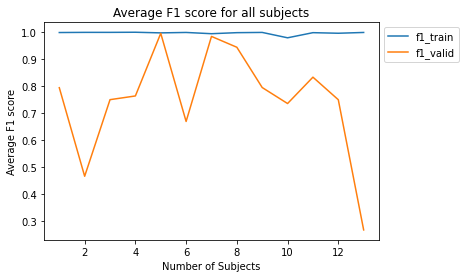

In [9]:
import matplotlib.pyplot as plt
num_subj = len(uni_subject)
x_axis = [i+1 for i in range(num_subj)]


plt.plot(x_axis,perfold_f1_train , label = 'f1_train')
plt.plot(x_axis,perfold_f1_test, label = 'f1_valid')

plt.xlabel('Number of Subjects')
 
plt.ylabel('Average F1 score')
plt.title('Average F1 score for all subjects')  
plt.legend(bbox_to_anchor=(1, 1)) 
plt.show()    

# Graph per subject¶

# Train Loss

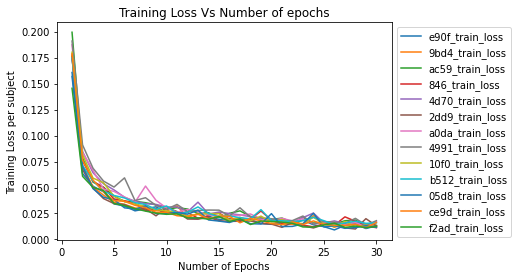

In [10]:
import matplotlib.pyplot as plt
num_epocs = 30
x_axis = [i+1 for i in range(num_epocs)]

for ind,i in enumerate(uni_subject):
    
    train_loss = str(i)+'_train_loss'
    locals()[train_loss] = sub_plot[ind]['loss']
    plt.plot(x_axis, locals()[train_loss], label = train_loss)

plt.xlabel('Number of Epochs')
 
plt.ylabel('Training Loss per subject')
plt.title('Training Loss Vs Number of epochs')  
plt.legend(bbox_to_anchor=(1, 1)) 
plt.show()    

# Training Accuracy

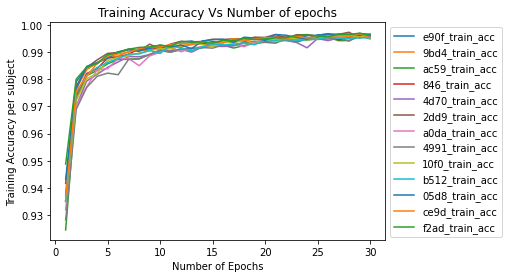

In [11]:
for ind,i in enumerate(uni_subject):
    train_acc = str(i)+'_train_acc'
    locals()[train_acc] = sub_plot[ind]['accuracy']
    plt.plot(x_axis, locals()[train_acc], label = train_acc)

plt.xlabel('Number of Epochs')
 
plt.ylabel('Training Accuracy per subject')
plt.title('Training Accuracy Vs Number of epochs')  
plt.legend(bbox_to_anchor=(1, 1)) 
plt.show() 

# Validation Loss

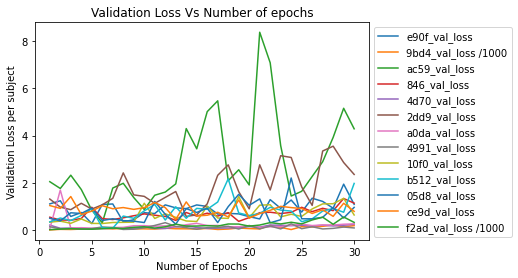

In [20]:
for ind,i in enumerate(uni_subject):
    if ind == 1 or ind == 12:
        validation_loss = str(i)+'_val_loss'
        locals()[validation_loss] = sub_plot[ind]['val_loss'] 
        #print(locals()[validation_loss])

        plt.plot(x_axis, np.array(locals()[validation_loss])/ 1000, label = validation_loss + ' /1000')
    else:
        validation_loss = str(i)+'_val_loss'
        locals()[validation_loss] = sub_plot[ind]['val_loss'] 

        plt.plot(x_axis, locals()[validation_loss], label = validation_loss)

plt.xlabel('Number of Epochs')

plt.ylabel('Validation Loss per subject')
plt.title('Validation Loss Vs Number of epochs')  
plt.legend(bbox_to_anchor=(1, 1)) 
plt.show() 

# Validation accuracy

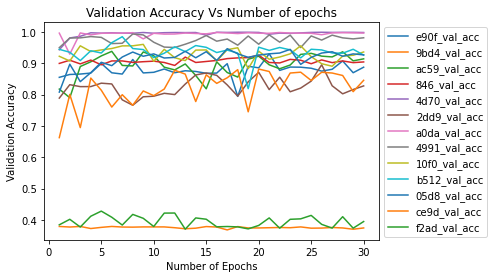

In [21]:
for ind,i in enumerate(uni_subject):
    val_acc = str(i)+'_val_acc'
    locals()[val_acc] = sub_plot[ind]['val_accuracy']
    plt.plot(x_axis, locals()[val_acc], label = val_acc)
    
    
plt.xlabel('Number of Epochs')

plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Vs Number of epochs')  
plt.legend(bbox_to_anchor=(1, 1))    
plt.show()

# Predictions

In [22]:
cls = np.array(range(5))
class_names = ['walking','running','standing','sitting','jumping']

print('\nTraining RESULTS: ')
print("\nAvg. Accuracy: {0}".format(jaccard_score(train_gt, train_preds, average='macro')))
print("Avg. Precision: {0}".format(precision_score(train_gt, train_preds, average='macro')))
print("Avg. Recall: {0}".format(recall_score(train_gt, train_preds, average='macro')))
print("Avg. F1: {0}".format(f1_score(train_gt, train_preds, average='macro')))

print("\nTraining RESULTS (PER CLASS): ")
print("\nAccuracy:")
for i, rslt in enumerate(jaccard_score(train_gt, train_preds, average=None, labels=cls)):
    print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nPrecision:")
for i, rslt in enumerate(precision_score(train_gt, train_preds, average=None, labels=cls)):
    print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nRecall:")
for i, rslt in enumerate(recall_score(train_gt, train_preds, average=None, labels=cls)):
    print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nF1:")
for i, rslt in enumerate(f1_score(train_gt, train_preds, average=None, labels=cls)):
    print("   {0}: {1} %".format(class_names[i], rslt*100))


Training RESULTS: 

Avg. Accuracy: 0.992824344934187
Avg. Precision: 0.9954712784009498
Avg. Recall: 0.9973178701878004
Avg. F1: 0.996386814282606

Training RESULTS (PER CLASS): 

Accuracy:
   walking: 99.57029591062155 %
   running: 99.89719423894223 %
   standing: 98.159172221315 %
   sitting: 99.98842458617897 %
   jumping: 98.79708551003574 %

Precision:
   walking: 99.91778606255642 %
   running: 99.9527519526732 %
   standing: 98.46907623345098 %
   sitting: 99.9976847028316 %
   jumping: 99.39834024896265 %

Recall:
   walking: 99.65193876799711 %
   running: 99.94438976377953 %
   standing: 99.68040040402212 %
   sitting: 99.99073945455388 %
   jumping: 99.39146670354747 %

F1:
   walking: 99.7846853473771 %
   running: 99.94857068332091 %
   standing: 99.07103579508848 %
   sitting: 99.99421195809458 %
   jumping: 99.39490335742195 %


# Validation Accuracies

In [23]:
print('\nValidation RESULTS: ')
print("\nAvg. Accuracy: {0}".format(jaccard_score(test_gt, test_preds, average='macro')))
print("Avg. Precision: {0}".format(precision_score(test_gt, test_preds, average='macro')))
print("Avg. Recall: {0}".format(recall_score(test_gt, test_preds, average='macro')))
print("Avg. F1: {0}".format(f1_score(test_gt, test_preds, average='macro')))

print("\nVALIDATION RESULTS (PER CLASS): ")
print("\nAccuracy:")
for i, rslt in enumerate(jaccard_score(test_gt, test_preds, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')

print("\nPrecision:")
for i, rslt in enumerate(precision_score(test_gt, test_preds, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    

print("\nRecall:")
for i, rslt in enumerate(recall_score(test_gt, test_preds, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    
print("\nF1:")
for i, rslt in enumerate(f1_score(test_gt, test_preds, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')


Validation RESULTS: 

Avg. Accuracy: 0.647050994175536
Avg. Precision: 0.8043431177272179
Avg. Recall: 0.7587673495762384
Avg. F1: 0.7712644630842812

VALIDATION RESULTS (PER CLASS): 

Accuracy:
walking: 78.0
running: 78.0
standing: 41.0
sitting: 81.0
jumping: 46.0

Precision:
walking: 90.0
running: 79.0
standing: 78.0
sitting: 93.0
jumping: 61.0

Recall:
walking: 85.0
running: 97.0
standing: 47.0
sitting: 86.0
jumping: 64.0

F1:
walking: 88.0
running: 87.0
standing: 57.99999999999999
sitting: 89.0
jumping: 63.0


In [24]:
print("\nGENERALIZATION GAP ANALYSIS: ")
print("\nTrain-Val-Accuracy Difference: {0}".format(jaccard_score(train_gt, train_preds, average='macro') -
                                                  jaccard_score(test_gt, test_preds, average='macro')))
print("Train-Val-Precision Difference: {0}".format(precision_score(train_gt, train_preds, average='macro') -
                                                   precision_score(test_gt, test_preds, average='macro')))
print("Train-Val-Recall Difference: {0}".format(recall_score(train_gt, train_preds, average='macro') -
                                                recall_score(test_gt, test_preds, average='macro')))
print("Train-Val-F1 Difference: {0}".format(f1_score(train_gt, train_preds, average='macro') -
                                            f1_score(test_gt, test_preds, average='macro')))


GENERALIZATION GAP ANALYSIS: 

Train-Val-Accuracy Difference: 0.345773350758651
Train-Val-Precision Difference: 0.19112816067373195
Train-Val-Recall Difference: 0.238550520611562
Train-Val-F1 Difference: 0.2251223511983248


# Testing on Game Data

In [25]:
print('game_data',game_data.shape)

label_game = game_data['locomotion']
x_axis_game = sorted(label_game.unique())
y_axis_game = label_game.value_counts()

X_game = game_data.iloc[:,:-1]


def adjust_lables(clean_data,data_y):
    clean_data[data_y == 'walking'] = 0
    clean_data[data_y == 'running'] = 1
    clean_data[data_y == 'standing'] = 2
    clean_data[data_y == 'sitting'] = 3
    clean_data[data_y == 'jumping'] = 4
    
    return data_y

y_game = adjust_lables(game_data,game_data.iloc[:,-1]).astype(int)

data_labelled_game = np.concatenate((X_game, y_game[:,None]), axis=1)[:,2:] 
print('data_labelled_game ',data_labelled_game.shape)

data_labelled_X = data_labelled_game[:,:-1]
data_labelled_Y = data_labelled_game[:,-1]

print(data_labelled_X.shape,data_labelled_Y.shape)

X_train_game, y_train_game = apply_sliding_window(data_labelled_X, data_labelled_Y, sliding_window_size=sw_length, 
                                        sampling_rate=50,sliding_window_overlap=sw_overlap)


X_train_game, y_train_game = X_train_game.astype(np.float32), y_train_game[:,0].astype(np.uint8)

print("\nShape of the X_train_game and y_train_game datasets after splitting and windowing: ")
print(X_train_game.shape, y_train_game.shape) 

game_data (728431, 6)


/home/shk/anaconda3/envs/adversarial/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


data_labelled_game  (728431, 4)
(728431, 3) (728431,)

Shape of the X_train_game and y_train_game datasets after splitting and windowing: 
(19168, 50, 3) (19168,)


# Loading pretrained model

In [26]:
model = load_model('./Pre_Trained_models/locomotion_LOSO')

pt = './Pre_Trained_models/locomotion_LOSO/locomotion_LOSO'
model.load_weights(pt)

In [27]:
loss_game,acc_game = model.evaluate(X_train_game,y_train_game)

print('___GAME___')
print(f'GAME_loss {round(loss_game,3)}, GAME_accuracy {round(acc_game,3)*100}')

599/599 [==============================] - 4s 7ms/step - loss: 131.2535 - accuracy: 0.5253
___GAME___
GAME_loss 131.253, GAME_accuracy 52.5


In [28]:
y_pred_game = np.argmax(model.predict(X_train_game), axis=-1)

#Training
acc_game = jaccard_score(y_train_game, y_pred_game, average='macro')
pre_game = precision_score(y_train_game, y_pred_game, average='macro', zero_division=0)
reca_game = recall_score(y_train_game, y_pred_game, average='macro', zero_division=0)
f1_game = f1_score(y_train_game, y_pred_game, average='macro', zero_division=0)

print("___GAME____")
print(f"accuracy {round(acc_game,3)*100} ,precision {round(pre_game,3)*100}, recall {round(reca_game,3)*100},f1_score {round(f1_game,3)*100} ")

___GAME____
accuracy 26.700000000000003 ,precision 39.2, recall 42.5,f1_score 38.4 


In [29]:
print('\nGame RESULTS: ')
print("\nAvg. Accuracy: {0}".format(jaccard_score(y_train_game, y_pred_game, average='macro')))
print("Avg. Precision: {0}".format(precision_score(y_train_game, y_pred_game, average='macro')))
print("Avg. Recall: {0}".format(recall_score(y_train_game, y_pred_game, average='macro')))
print("Avg. F1: {0}".format(f1_score(y_train_game, y_pred_game, average='macro')))

print("\nGAME RESULTS (PER CLASS): ")
print("\nAccuracy:")
for i, rslt in enumerate(jaccard_score(y_train_game, y_pred_game, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    #print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nPrecision:")
for i, rslt in enumerate(precision_score(y_train_game, y_pred_game, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    #print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nRecall:")
for i, rslt in enumerate(recall_score(y_train_game, y_pred_game, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    #print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nF1:")
for i, rslt in enumerate(f1_score(y_train_game, y_pred_game, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    #print("   {0}: {1} %".format(class_names[i], rslt*100))


Game RESULTS: 

Avg. Accuracy: 0.26726311275819825
Avg. Precision: 0.39234407090385776
Avg. Recall: 0.4250372289044947
Avg. F1: 0.3842043198582542

GAME RESULTS (PER CLASS): 

Accuracy:
walking: 43.0
running: 33.0
standing: 4.0
sitting: 49.0
jumping: 4.0

Precision:
walking: 77.0
running: 42.0
standing: 6.0
sitting: 66.0
jumping: 5.0

Recall:
walking: 49.0
running: 60.0
standing: 14.000000000000002
sitting: 66.0
jumping: 23.0

F1:
walking: 60.0
running: 49.0
standing: 9.0
sitting: 66.0
jumping: 8.0


# END